# 10. Non hierarchical clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# Big five theory

S = """あなた自身にどのくらい当てはまるか、７段階で答えてください。
    1: 全く違うと思う
    2: おおよそ違うと思う
    3: 少し違うと思う
    4: どちらでもない
    5: 少しそう思う
    6: まあまあそう思う
    7: 強くそう思う
"""

A = [
    ["活発で、外向的だと思う", 0],
    ["他人に不満をもち、もめごとを起こしやすいと思う", 0],
    ["しっかりしていて、自分に厳しいと思う", 0],
    ["心配性で、うろたえやすいと思う", 0],
    ["新しいことが好きで、変わった考えをもつと思う", 0],
    ["ひかえめで、おとなしいと思う", 0],
    ["人に気をつかう、やさしい人間だと思う", 0],
    ["だらしなく、うっかりしていると思う", 0],
    ["冷静で、気分が安定していると思う", 0],
    ["発想力に欠けた、平凡な人間だと思う", 0],
]

def tipij(A):
    v = [a[1] for a in A]
    return {
        '外向性': (v[0] + (8 - v[5])) / 2,
        '協調性': ((8 - v[1]) + v[6]) / 2,
        '勤勉性': (v[2] + (8 - v[7])) / 2,
        '神経症傾向': (v[3] + (8 - v[8])) / 2,
        '開放性': (v[4] + (8 - v[9])) / 2
    }

print(S, end='')
for a in A:
    a[1] = int(input(a[0]))
tipij(A)

あなた自身にどのくらい当てはまるか、７段階で答えてください。
    1: 全く違うと思う
    2: おおよそ違うと思う
    3: 少し違うと思う
    4: どちらでもない
    5: 少しそう思う
    6: まあまあそう思う
    7: 強くそう思う


{'外向性': 3.5, '協調性': 3.5, '勤勉性': 5.5, '神経症傾向': 3.5, '開放性': 4.0}

## 10.3 Lloyd's algorithm

In [3]:
def initialize_plot(ax, X, has_message=True):
    d = 1.5 if has_message else 1.
    ax.set_xlim(X[:,0].min()-1, X[:,0].max()+1)
    ax.set_ylim(X[:,1].min()-d, X[:,1].max()+1)
    ax.set_aspect('equal')

def draw_kmeans(ax, X, y=None, centers=None, wcss=None, msg='', arrowstyle='-'):
    
    def get_annotation_position(p, center, dist=0.5):
        delta = p - center
        delta /= np.linalg.norm(delta)
        return p + delta * dist
        
    artist = []
    center = X.mean()
    
    # Draw data points.
    colors = y if y is not None else 'black'
    artist.append(ax.scatter(X[:,0], X[:,1], c=colors, marker='.'))

    # Draw cluster centers.
    if centers is not None:
        artist.append(ax.scatter(centers[:,0], centers[:,1], marker='x', c=range(len(centers))))

    # Draw cluster IDs.
    if centers is not None:
        for i, mu in enumerate(centers):
            p = get_annotation_position(mu, center)
            artist.append(ax.text(p[0], p[1], f'{i+1}', ha='center', va='center'))

    # Draw dotted lines between cluster centers and members.
    if centers is not None and y is not None:
        for i, x in enumerate(X):
            cid = y[i]
            artist.append(
                ax.annotate(
                    '', xy=x, xytext=centers[cid],
                    arrowprops=dict(
                        arrowstyle=arrowstyle, 
                        linestyle="--",
                        shrinkA=0,
                        shrinkB=0,
                        color='tab:gray'
                    )
                )
            )

    # Draw the message.
    if msg:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        artist.append(ax.text(xmin+0.2, ymin+0.2, msg))

    return artist

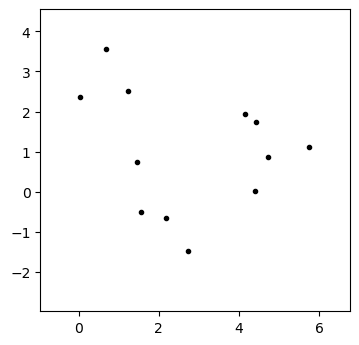

In [4]:
X, y = datasets.make_blobs(n_samples=12, random_state=0)
X = np.fliplr(X)
fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X)
plt.show()

In [7]:
def kmeans(X, num_clusters, max_iterations=1000, seed=0, H=None):
    # H : Record history of centers and assignments if H is True
    n,d = X.shape
    wcss = 0. # within-cluster sum-of-squares
    y = np.zeros(n, dtype=int)
    y_old = None

    # Random generator
    rng = np.random.default_rng(seed)

    # Initial centers
    centers = X[rng.permutation(n)[:num_clusters]]

    # Loop
    for t in range(max_iterations):
        wcss = 0. 

        # Record centers
        if H is not None:
            H.append([t, 'center', centers.copy()])

        # Find cluster assignments
        for i in range(n):
            dist = ((X[i] - centers) ** 2).sum(1)
            y[i] = np.argmin(dist)
            wcss += dist[y[i]]
        
        # Record centers
        if H is not None:
            H.append([t, 'assign', wcss, y.copy()])

        # Terminate if the assignment was unchanged
        if np.all(y == y_old):
            break

        # Compute the geometric center of each cluster
        for c in range(num_clusters):
            indices = np.where(y == c)
            centers[c] = X[indices].mean(0)

        # Store the current assignment
        y_old = y.copy()

    return y, centers, wcss

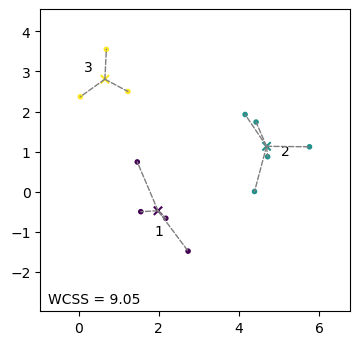

In [8]:
num_clusters=3
seed = 8
y_pred, centers, wcss = kmeans(X, num_clusters=num_clusters, seed=seed)

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, centers, msg=f'WCSS = {wcss:.2f}')
plt.show()

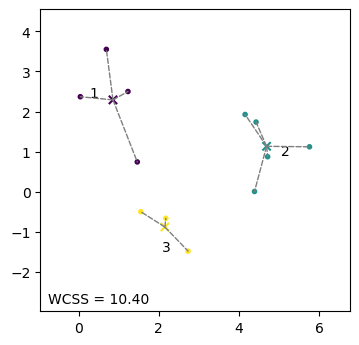

In [9]:
num_clusters=3
seed = 0
y_pred, centers, wcss = kmeans(X, num_clusters=num_clusters, seed=seed)

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, centers, msg=f'WCSS = {wcss:.2f}')
plt.show()

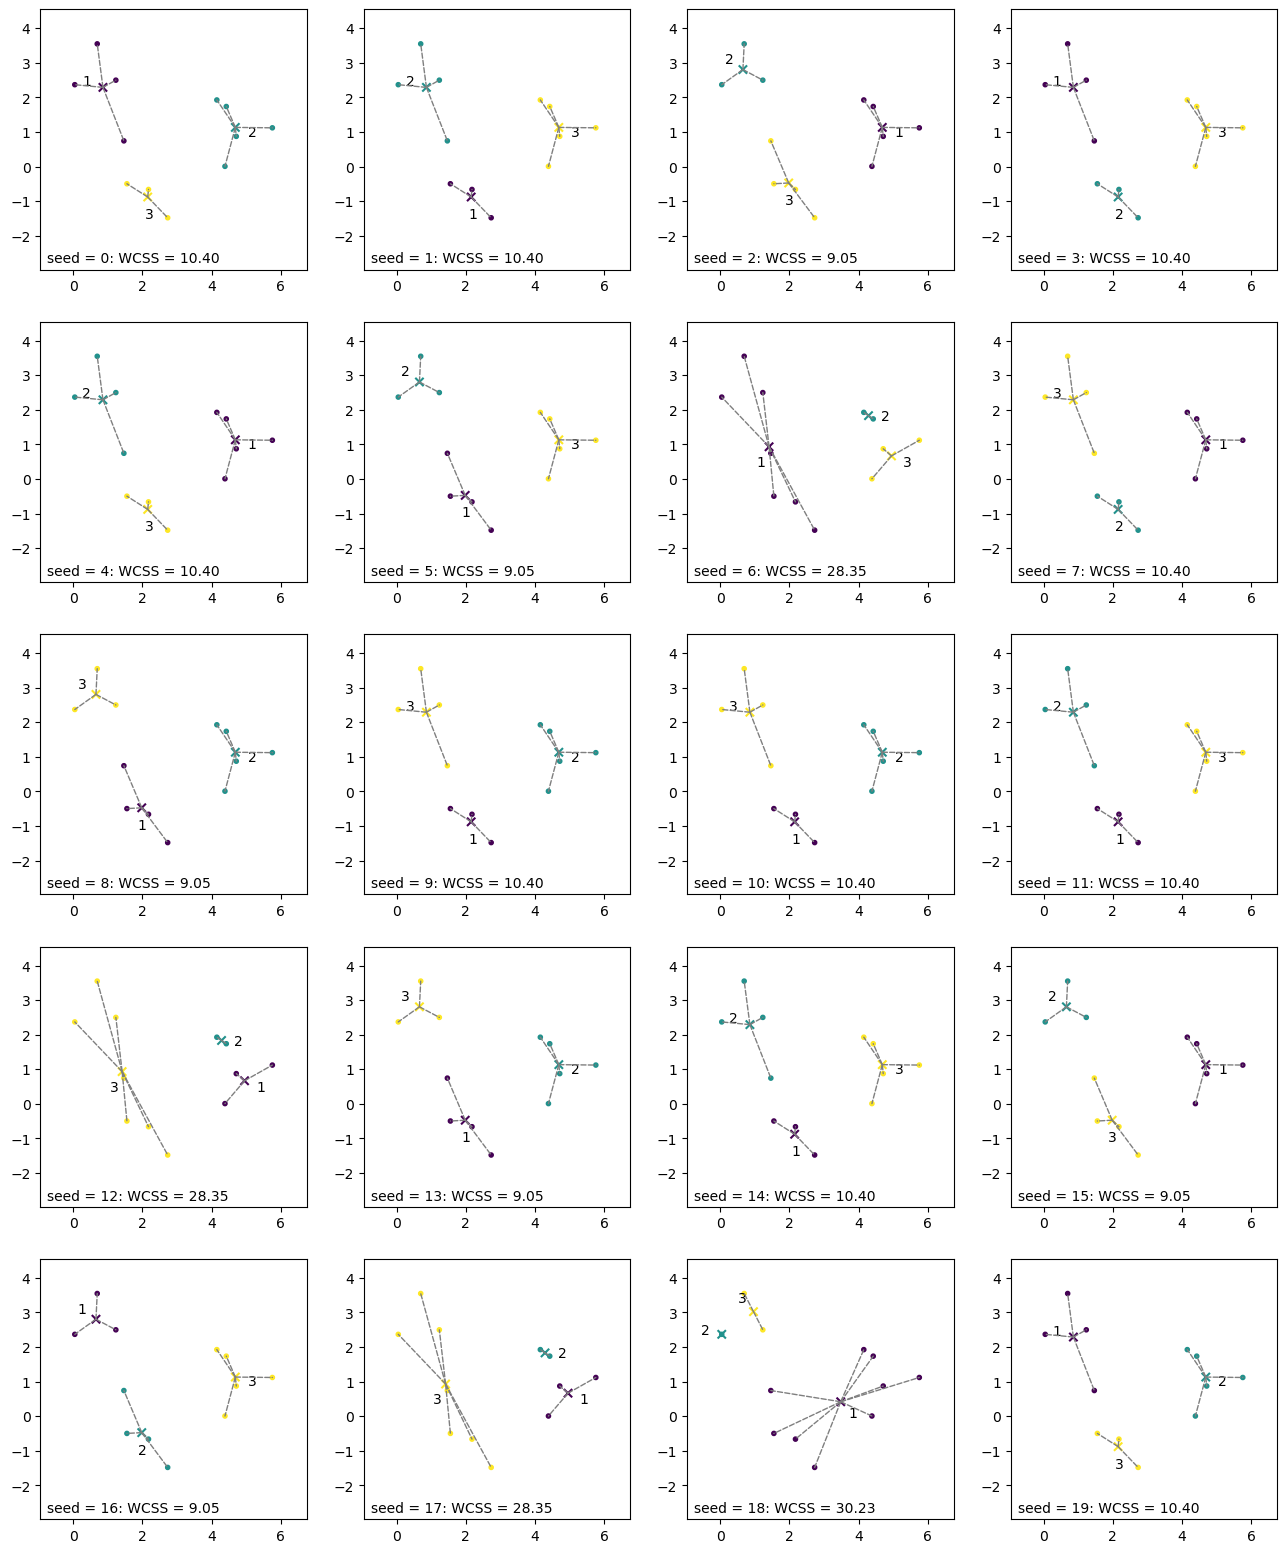

In [10]:
# Influence of the seed on the clustering
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(16, 20))

for i in range(20):
    ax = axes[i // 4][i % 4]
    initialize_plot(ax, X)
    y_pred, centers, wcss = kmeans(X, num_clusters, seed=i)
    draw_kmeans(ax, X, y_pred, centers, msg=f'seed = {i}: WCSS = {wcss:.2f}')
plt.show()

## 10.5 scikit-learn

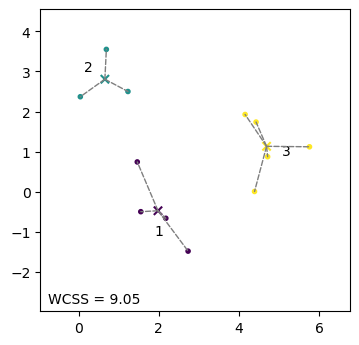

In [11]:
from sklearn.cluster import KMeans 
model = KMeans(n_clusters=3)
model.fit(X)
y_pred = model.labels_

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, model.cluster_centers_, msg=f'WCSS = {model.inertia_:.2f}')
plt.show()

## 10.6 A method to determine num_clusters

C:\Users\hiroe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


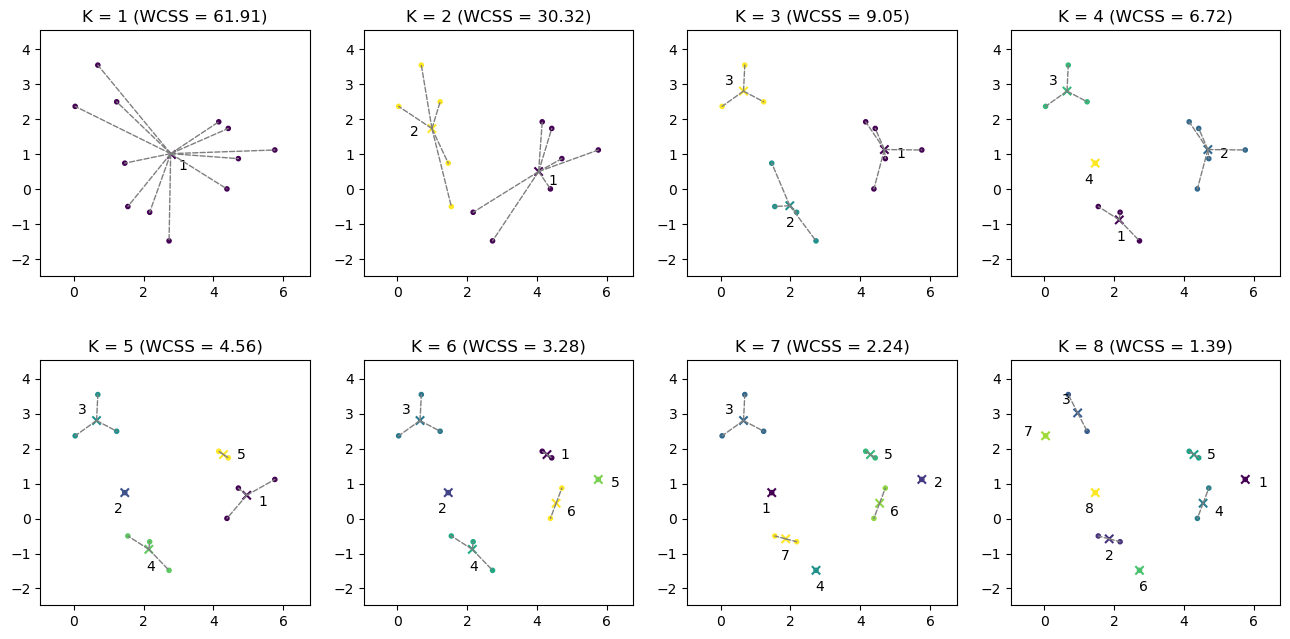

In [12]:
fig, axes = plt.subplots(2, 4, dpi=100, figsize=(16, 8))

J = []
for n in range(8):
    num_clusters = n+1
    model = KMeans(n_clusters=num_clusters)
    model.fit(X)
    y_pred = model.labels_
    J.append(model.inertia_)

    ax = axes[n // 4][n % 4]
    initialize_plot(ax, X, has_message=False)
    ax.set_title(f'K = {num_clusters} (WCSS = {model.inertia_:.2f})')
    draw_kmeans(ax, X, y_pred, model.cluster_centers_)

plt.show()

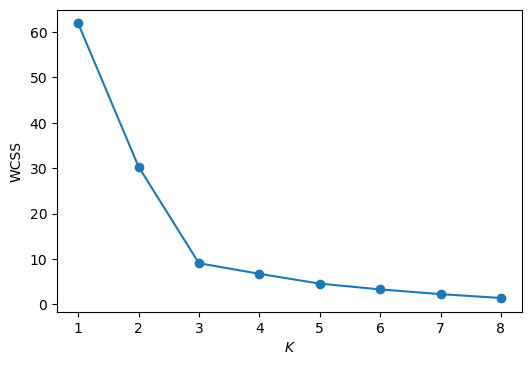

In [13]:
fig, ax = plt.subplots(dpi=100)
ax.plot(list(range(1, 9)), J, 'o-')
ax.set_xlabel('$K$')
ax.set_ylabel('WCSS')
plt.show()

## 10.7 Voronoi diagram

In [14]:
num_clusters = 3
model = KMeans(n_clusters=num_clusters)
model.fit(X)
y_pred = model.labels_
centers = model.cluster_centers_

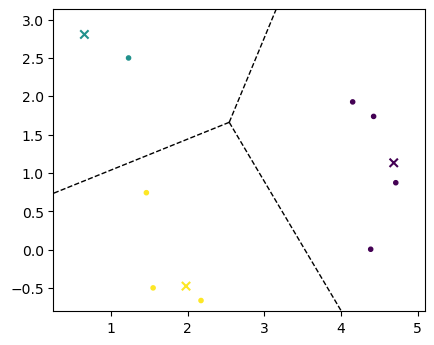

In [15]:
from scipy.spatial import Voronoi, voronoi_plot_2d

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.scatter(X[:, 0], X[:, 1], c=y_pred, marker='.')
ax.scatter(centers[:, 0], centers[:, 1], marker='x', c=range(num_clusters))

vor = Voronoi(centers)
voronoi_plot_2d(vor, ax, show_points=False, show_vertices=False)
plt.show()

## 10.8 Features of K-means

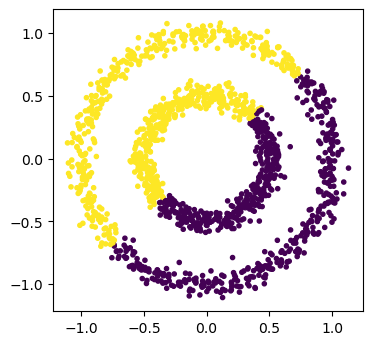

In [18]:
X, y = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)
model = KMeans(n_clusters=2)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()

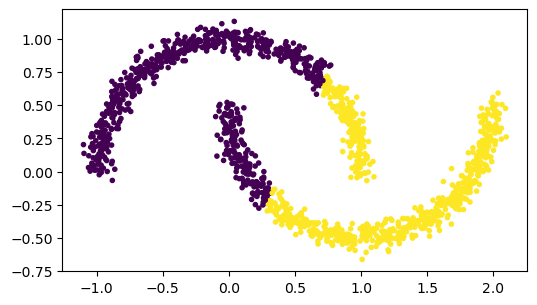

In [21]:
X, y = datasets.make_moons(1500, noise=.05)
model = KMeans(n_clusters=2)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()

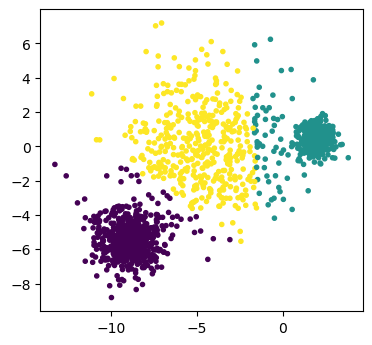

In [20]:
X, y = datasets.make_blobs(1500, cluster_std=[1.0, 2.5, 0.5], random_state=170)
model = KMeans(n_clusters=3)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()

## 10.9 Application for color reduction

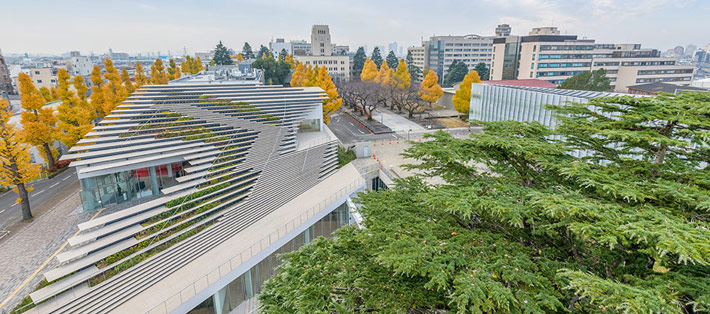

In [22]:
import io
import requests 
from PIL import Image

img = Image.open(io.BytesIO(requests.get("https://www.titech.ac.jp/news/img/news-26569-title.jpg").content))

img

In [24]:
m = np.array(img)
print(m.shape)
print(m[0][0])

(314, 710, 3)
[201 217 230]


In [25]:
X = m.reshape(-1, 3)
print(X.shape)

(222940, 3)


In [26]:
model = KMeans(n_clusters=8) # Reduction to 8 colors
model.fit(X)

KMeans()

<ipython-input-27-d6f54908ba02>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


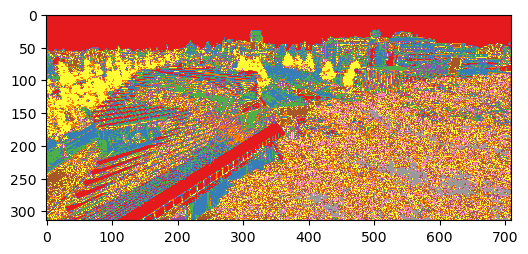

In [27]:
label_matrix = model.labels_.reshape(m.shape[0], m.shape[1])
fig, ax = plt.subplots(dpi=100)
ax.imshow(label_matrix, cmap=plt.get_cmap('Set1'))
fig.show()

In [28]:
print(model.cluster_centers_) # Representative colors

[[213.39858275 216.18544101 219.47554713]
 [102.32871574 109.60125314 111.68428456]
 [148.98697135 154.38304911 142.5175648 ]
 [ 82.66009809  98.61977074  49.78040061]
 [183.97063445 137.10744451  32.82174425]
 [183.8874821  185.3189012  182.86306429]
 [123.89652717 143.56957519  76.02875564]
 [ 41.74470856  56.13714317  22.89471399]]


In [30]:
palette = model.cluster_centers_.astype(int)
print(palette)

[[213 216 219]
 [102 109 111]
 [148 154 142]
 [ 82  98  49]
 [183 137  32]
 [183 185 182]
 [123 143  76]
 [ 41  56  22]]


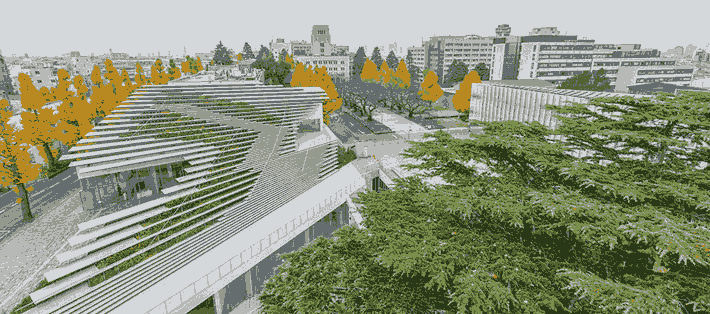

In [31]:
image_decoded = palette[label_matrix]
Image.fromarray(np.uint8(image_decoded))

## 10.10 Exercise
Clustering prefectures depending on consumption behavior

In [35]:
import pandas as pd

In [43]:
df = pd.read_csv('SSDSE-C-2021.csv', encoding='SHIFT=JIS')

In [44]:
df.info

<bound method DataFrame.info of    SSDSE-C-2021 Prefecture   City  LA03     LB00   LB01 LB011001 LB012001  \
0         地域コード       都道府県      市  世帯人員   食料（合計）  01　穀類        米      食パン   
1        R00000         全国     全国  2.97   960026  79312    23815     9860   
2        R01100        北海道    札幌市  2.91   939747  82676    31228     9075   
3        R02201        青森県    青森市  2.93   897288  73381    23652     8492   
4        R03201        岩手県    盛岡市  3.11   950535  80606    25033     8472   
5        R04100        宮城県    仙台市  3.03   968029  73349    20338     8630   
6        R05201        秋田県    秋田市  2.78   910130  67703    19704     6918   
7        R06201        山形県    山形市  3.14   983054  79164    26068     7478   
8        R07201        福島県    福島市  2.96   937721  73338    23738     7482   
9        R08201        茨城県    水戸市  2.88   924724  69248    19099     8878   
10       R09201        栃木県   宇都宮市  2.91   964692  76447    21578    10035   
11       R10201        群馬県    前橋市  2.84   93

In [57]:
X_pd = df.drop(['SSDSE-C-2021', 'Prefecture', 'City'], axis=1)
X = X_pd[2:].values.astype(float)
print(X.shape)
print(X[:2])

(47, 226)
[[2.91000e+00 9.39747e+05 8.26760e+04 3.12280e+04 9.07500e+03 1.81680e+04
  3.16200e+03 2.08200e+03 1.26600e+03 4.15200e+03 5.18900e+03 1.60900e+03
  7.26000e+02 6.64000e+02 1.93600e+03 3.42000e+03 8.44090e+04 4.89900e+03
  1.83000e+02 2.82000e+02 9.36000e+02 1.67200e+03 7.43100e+03 7.60000e+02
  1.08600e+03 5.22000e+02 1.26600e+03 2.08700e+03 1.41500e+03 3.40200e+03
  1.96800e+03 8.73500e+03 3.87800e+03 6.85000e+02 5.44000e+02 8.40000e+02
  2.40800e+03 8.07000e+02 3.09600e+03 2.40900e+03 8.48000e+02 2.35000e+02
  1.00600e+04 1.53800e+03 1.44200e+03 3.78800e+03 1.25800e+03 6.49000e+02
  5.10200e+03 5.92000e+02 2.96400e+03 4.62200e+03 8.89240e+04 1.24470e+04
  3.29400e+04 1.61860e+04 1.78100e+03 4.94400e+03 4.44900e+03 8.16600e+03
  3.46000e+03 4.55300e+03 4.36230e+04 1.30700e+04 1.14000e+03 1.11200e+04
  1.65900e+03 7.47600e+03 5.26000e+02 8.63200e+03 1.09625e+05 3.10000e+03
  2.64300e+03 1.64000e+03 3.32400e+03 2.49400e+03 2.26800e+03 1.08500e+03
  8.98000e+03 1.36600e+03 2.

C:\Users\hiroe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


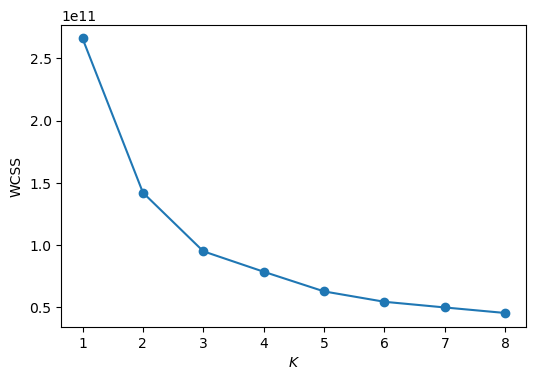

In [58]:
# K-means
K_range=8

J = []
for i in range(K_range):
    n_clusters = i + 1
    model = KMeans(n_clusters=n_clusters)
    model.fit(X)
    J.append(model.inertia_)

fig, ax = plt.subplots(dpi=100)
ax.plot(list(range(1, 9)), J, 'o-')
ax.set_xlabel('$K$')
ax.set_ylabel('WCSS')
plt.show()

In [66]:
# K = 4
model = KMeans(n_clusters=4)
model.fit(X)
y_pred = model.labels_
city = df['City'][2:]
for i in range(4):
    print(city[y_pred == i])

2     札幌市
3     青森市
4     盛岡市
6     秋田市
8     福島市
9     水戸市
11    前橋市
16    新潟市
21    長野市
32    鳥取市
33    松江市
34    岡山市
36    山口市
37    徳島市
38    高松市
42    佐賀市
Name: City, dtype: object
31    和歌山市
39     松山市
43     長崎市
44     熊本市
45     大分市
46     宮崎市
47    鹿児島市
48     那覇市
Name: City, dtype: object
5      仙台市
7      山形市
10    宇都宮市
19     福井市
20     甲府市
22     岐阜市
23     静岡市
24    名古屋市
25      津市
26     大津市
27     京都市
28     大阪市
29     神戸市
30     奈良市
35     広島市
40     高知市
41     福岡市
Name: City, dtype: object
12    さいたま市
13      千葉市
14    東京都区部
15      横浜市
17      富山市
18      金沢市
Name: City, dtype: object
